In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch    
from sklearn.decomposition import PCA
import hydra

from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import *
from openretina.models.core_readout import load_core_readout_from_remote
from openretina.data_io.hoefling_2024.stimuli import movies_from_pickle
from openretina.utils.file_utils import get_local_file_path

# Load model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "hoefling_2024_base_low_res"
model = load_core_readout_from_remote(
    model_name, device="cuda" if torch.cuda.is_available() else "cpu"
)
model

CoreReadout(
  (core): <super: <class 'Core'>, <SimpleCoreWrapper object>> [SimpleCoreWrapper regularizers: gamma_hidden = 0.0|gamma_in_sparse = 0.0|gamma_input = 0.0|gamma_temporal = 40.0]
  
  (readout): MultiGaussianReadoutWrapper(
    (session_1_ventral1_20200226): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 80)
    
    (session_1_ventral1_20200528): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 42)
    
    (session_1_ventral1_20200707): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 74)
    
    (session_1_ventral1_20201021): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 32)
    
    (session_1_ventral1_20201030): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 40)
    
    (session_1_ventral1_20210929): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 48)
    
    (session_1_ventral1_20210930): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 26)
    
    (session_1_ventral2_20200302): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 41)
    
    (session_1_ventral2_20200707): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 56)
    
    (sess

In [3]:
# pick a random session
session_id = list(model.readout.keys())[1]
print(session_id)
n_neurons = model.readout[session_id].outdims
print(f"Number of neurons: {n_neurons}")

session_1_ventral1_20200528
Number of neurons: 42


In [4]:
assignments = model.data_info['sessions_kwargs']['session_1_ventral1_20200707']['group_assignment']
assignments

array([22, 31, 31, 17, 22, 32, 31,  3, 32, 17, 28, 32, 17, 32, 32,  5, 22,
       32, 22, 22, 17, 11, 12, 20, 12, 32, 12, 22, 31,  8, 22, 31, 23, 17,
       11, 20, 11, 20, 32, 32, 22, 11, 22, 12, 24, 23, 23, 24, 32, 31, 20,
       11, 17, 11, 22,  7, 22, 23, 32, 23, 23,  6, 24, 32, 11, 18, 20, 17,
       23, 23, 24, 22, 22, 14], dtype=int32)

In [5]:
sessions = list(model.readout.keys())

# Find all sessions with group assignment 10 and their positions
# Initialize a dictionary to store groups, sessions, and cell IDs
group_sessions_cells = {}

# Iterate through all sessions
for session in sessions:
    # Get assignments for this session
    assignments = model.data_info["sessions_kwargs"][session]["group_assignment"]

    # Get number of neurons for this session
    n_neurons = model.readout[session].outdims

    # For each cell in this session
    for cell_id in range(n_neurons):
        group = int(assignments[cell_id])  # Convert to int for dictionary key

        # Initialize group if not exists
        if group not in group_sessions_cells:
            group_sessions_cells[group] = {}

        # Initialize session if not exists for this group
        if session not in group_sessions_cells[group]:
            group_sessions_cells[group][session] = []

        # Add cell ID to the appropriate group and session
        group_sessions_cells[group][session].append(cell_id)

group_sessions_cells[10]


{'session_1_ventral1_20201030': [22],
 'session_1_ventral2_20201021': [25],
 'session_1_ventral2_20210910': [37],
 'session_1_ventral2_20210929': [6, 35],
 'session_2_ventral1_20200529': [0],
 'session_2_ventral1_20200701': [1],
 'session_2_ventral1_20201021': [24],
 'session_2_ventral1_20201030': [53],
 'session_2_ventral2_20201016': [4],
 'session_2_ventral2_20201021': [37],
 'session_2_ventral2_20201117': [34],
 'session_2_ventral2_20210910': [9],
 'session_2_ventral2_20210921': [16],
 'session_2_ventral2_20210929': [18],
 'session_2_ventral2_20210930': [29],
 'session_3_ventral1_20200226': [23],
 'session_3_ventral1_20200529': [29],
 'session_3_ventral1_20201030': [0, 37, 45],
 'session_3_ventral2_20200707': [8],
 'session_3_ventral2_20201117': [4, 24],
 'session_3_ventral2_20210910': [4],
 'session_4_ventral1_20201021': [36],
 'session_4_ventral2_20200303': [32],
 'session_4_ventral2_20210910': [5],
 'session_5_ventral2_20200303': [14],
 'session_5_ventral2_20210921': [7],
 'sessi

# Load natural images

In [6]:
# For Hoefling et al, let's load training data
with hydra.initialize(config_path=os.path.join("..", "configs"), version_base="1.3"):
    cfg = hydra.compose(config_name="hoefling_2024_core_readout_low_res.yaml")

movies_path = get_local_file_path(file_path=cfg.paths.movies_path, cache_folder=cfg.paths.data_dir)

movies_dict = movies_from_pickle(movies_path)

(<matplotlib.image.AxesImage at 0x7e20d2eb8830>, (2, 16200, 18, 16))

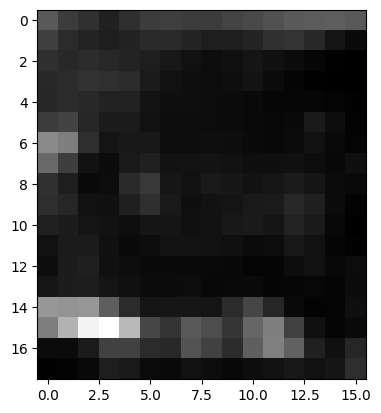

In [7]:
plt.imshow(movies_dict.train[0,2500], cmap='gray'), movies_dict.train.shape

In [8]:
n_images = 3000
rate = movies_dict.train.shape[1] // n_images
natural_images_library = movies_dict.train[:, ::rate, :, :].swapaxes(0, 1)

In [9]:
natural_images_library.shape

(3240, 2, 18, 16)

In [10]:
movies, n_empty_frames = prepare_movies_dataset(model, session_id,
    normalize_movies=False, # Already normalized
    image_library=natural_images_library, n_image_frames=60, device = device)
# 16 frames * 30 Hz = 0.53 seconds integration window

Model input shape: [2, 18, 16]
Using provided image library with shape: (3240, 2, 18, 16)
Image stats- Mean: -0.01, Std: 1.00, Min: -0.9178165417762062, Max: 6.2587746894023235
Number of empty frames needed: 30
Final movies shape: (3240, 2, 90, 18, 16)


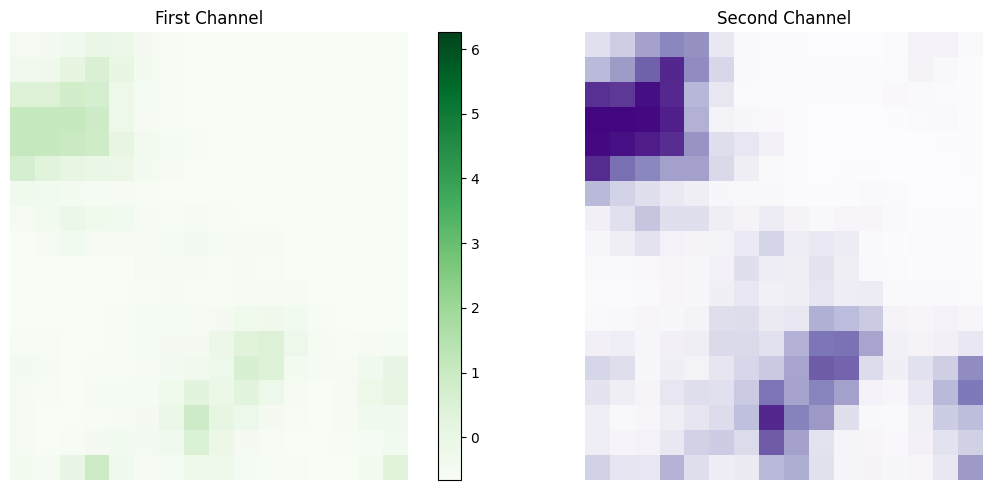

First channel range: [-0.659, 1.077]


In [11]:
# Display the last frame of an example movie with both channels side by side
example_idx = 135  # First movie as example
last_frame = movies[example_idx, :, -1] # movies[example_idx, :, -1]  # Shape: (2, 72, 64)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First channel (channel 0)
im1 = axes[0].imshow(last_frame[0], cmap='Greens', vmin=movies[:, 0].min(), vmax=movies[:, 0].max())
axes[0].set_title('First Channel')
plt.colorbar(im1, ax=axes[0])
axes[0].axis('off')
# Optional : Second channel (channel 1) 
im2 = axes[1].imshow(last_frame[1], cmap='Purples', vmin=movies[:, 1].min(), vmax=movies[:, 1].max())
axes[1].set_title('Second Channel')
# plt.colorbar(im2, ax=axes[1])
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f"First channel range: [{last_frame[0].min():.3f}, {last_frame[0].max():.3f}]")
# print(f"Second channel range: [{last_frame[1].min():.3f}, {last_frame[1].max():.3f}]")

In [12]:
cell_id = 0  # LInear example | cell_id = 33 NONLINEAR Example
lsta_library, response_library = compute_lsta_library(
    model,
    movies[:n_images], # Can limit number of images for it to run faster
    session_id,
    cell_id,
    integration_window=(5, 5+35),  # Integration window for the LSTA
    batch_size=64,
    device=device,
)

In [13]:
lsta_library.shape, response_library.shape

((3000, 2, 18, 16), (3000, 70, 42))

Text(0, 0.5, 'Cell predicted Response (au)')

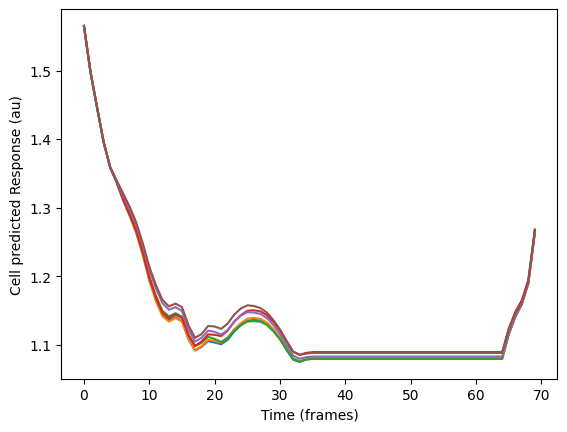

In [14]:
# We can check some sample responses, making sure the integrity of the response profile is predicted and we did not cut it too short.

plt.plot(response_library[0, :, cell_id])
plt.plot(response_library[1, :, cell_id])
plt.plot(response_library[2, :, cell_id])
plt.plot(response_library[3, :, cell_id])
plt.plot(response_library[4, :, cell_id])
plt.plot(response_library[5, :, cell_id])
plt.xlabel('Time (frames)')
plt.ylabel('Cell predicted Response (au)')

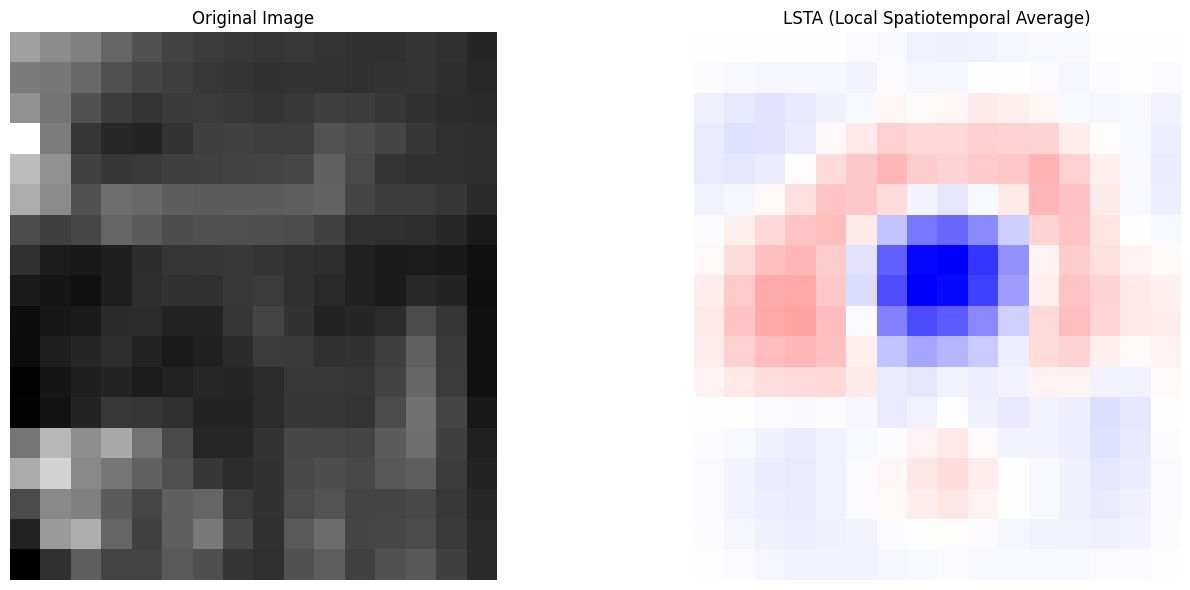

In [15]:
# We can now plot an example LSTA and the corresponding image

image = 450
channel = 1
lsta = lsta_library[image, channel]
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# image
axes[0].imshow(movies[image,0,-1], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# LSTA
axes[1].imshow(lsta, cmap='bwr', vmin=-abs(lsta).max(), vmax=abs(lsta).max())
axes[1].set_title('LSTA (Local Spatiotemporal Average)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Do PCA on the LSTA library

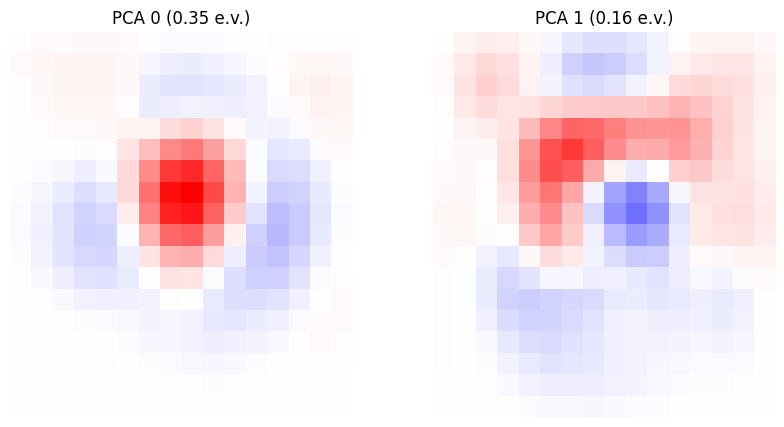

In [16]:
# Select channel
channel = 1
# lsta_library = lsta_library[:, :, :]

PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)

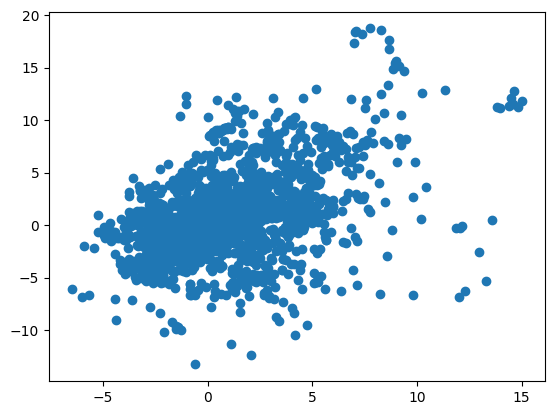

In [17]:
# Project the images onto PCA space
images = movies[:,channel,-1,:,:]
images_coordinate = get_images_coordinate(images, PC1, PC2, plot=True)

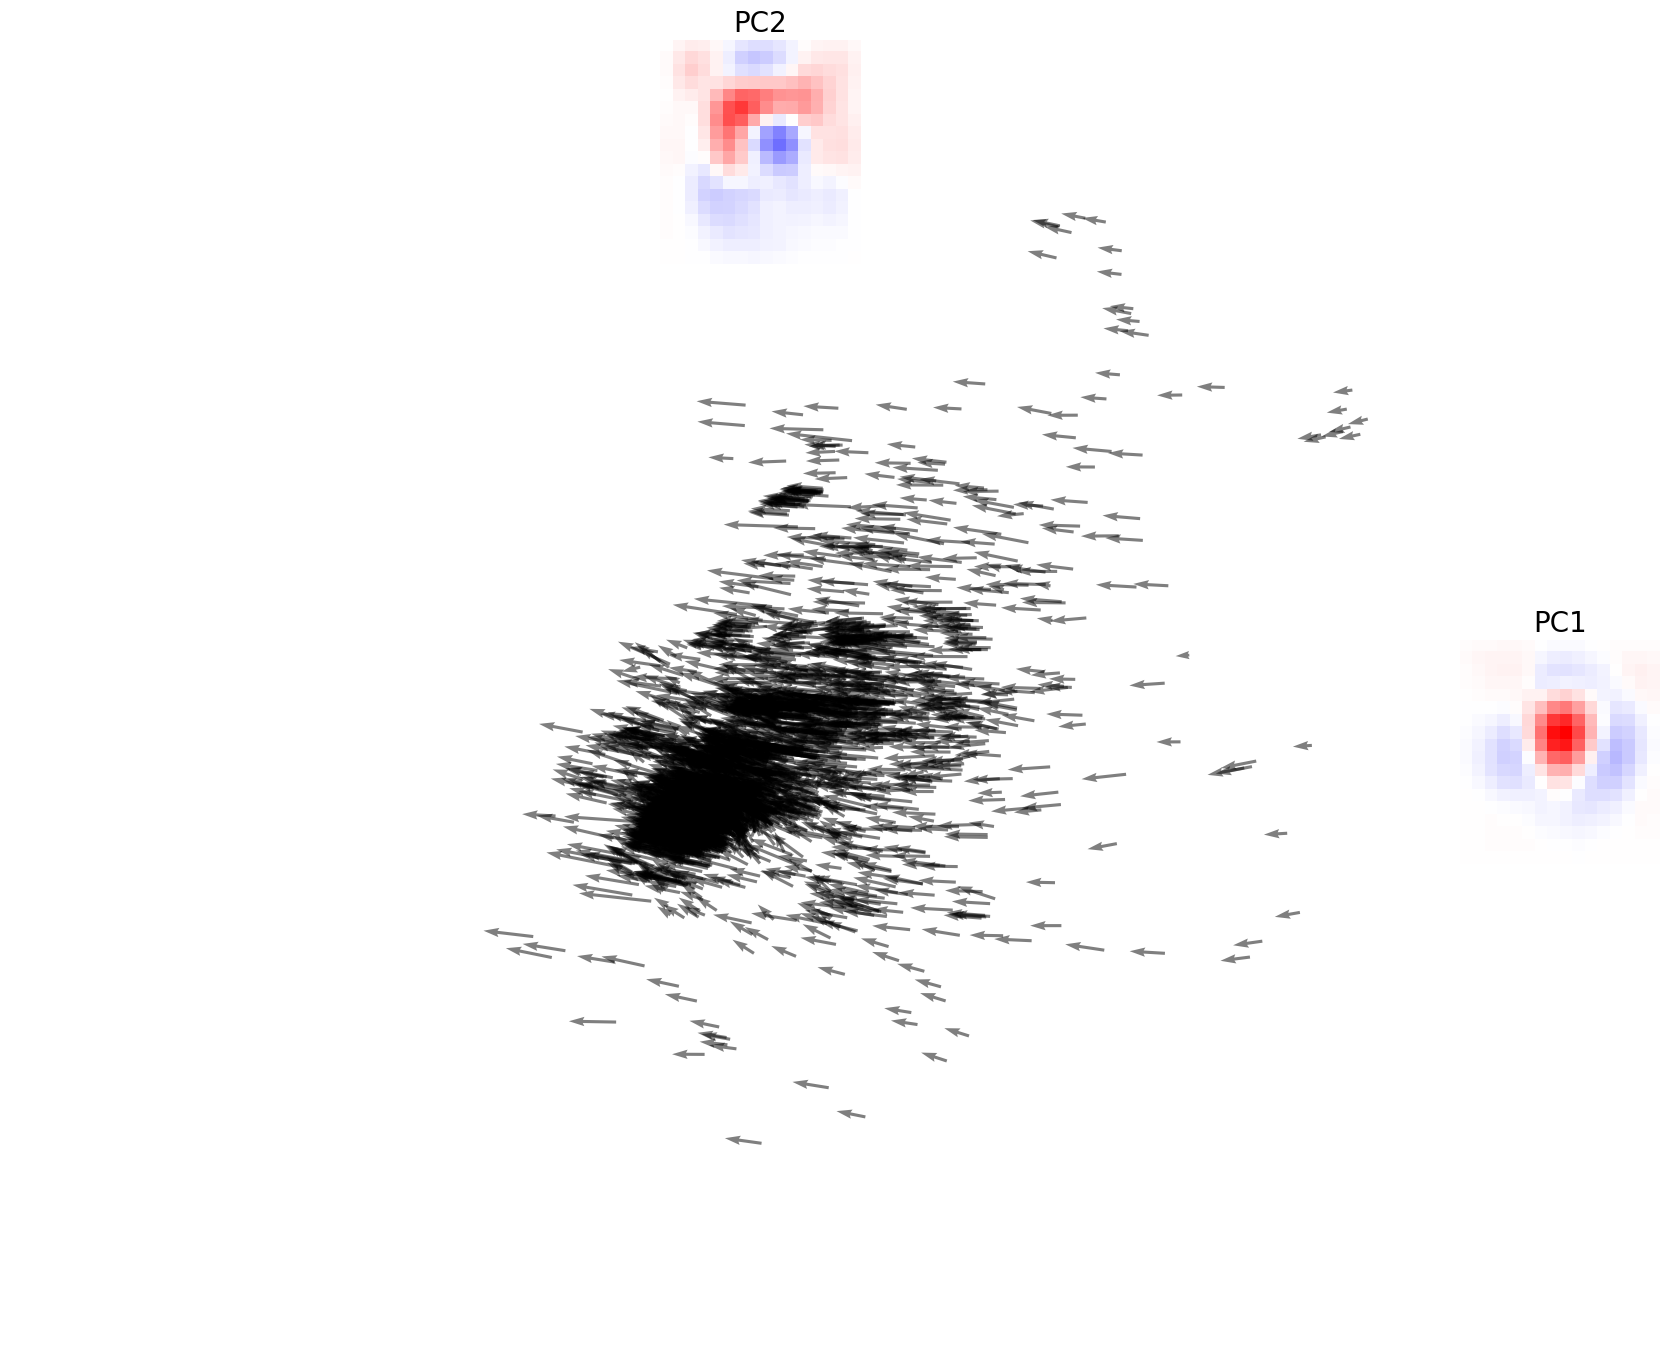

In [18]:
# Plot the vector field of the LSTA in PCA space
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_untreated_vectorfield

fig = plot_untreated_vectorfield(lsta_library, channel, PC1, PC2, images_coordinate)

/tmp/ipykernel_163859/3326828446.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


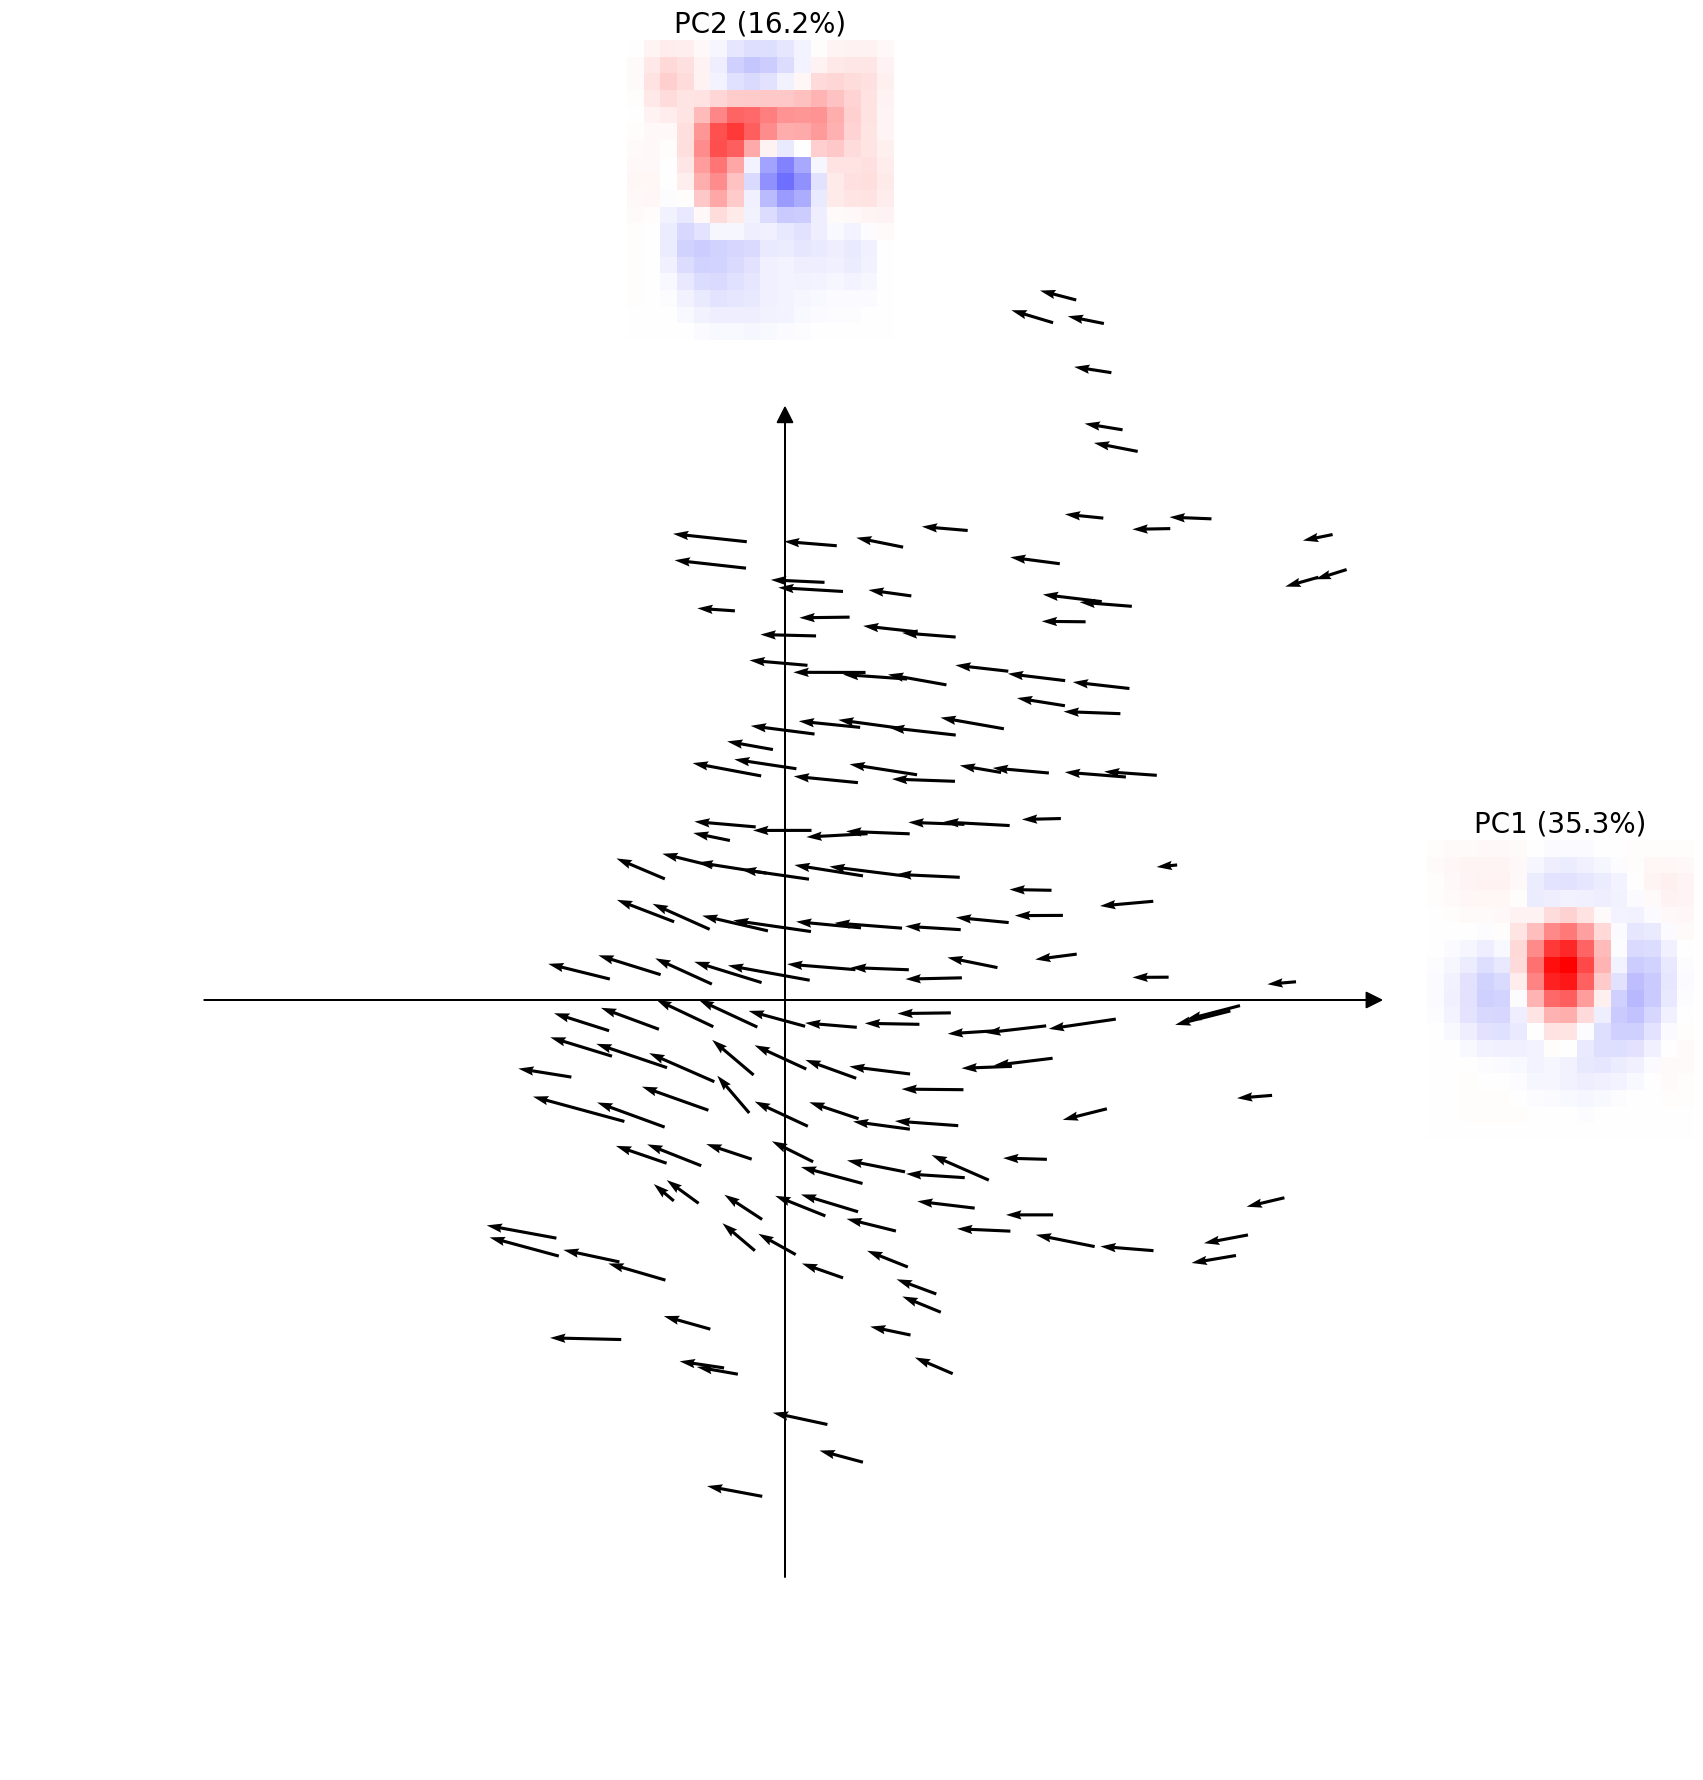

In [19]:
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_clean_vectorfield
fig = plot_clean_vectorfield(
    lsta_library,
    channel,
    PC1,
    PC2,
    images,
    images_coordinate,
    explained_variance,
    x_bins=30,
    y_bins=30,
)
fig.show()

# ADD the firing rate by the side + mention cell types

# Create all arrowplots of a session

In [ ]:
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_clean_vectorfield

for session_id in model.readout.keys():
    os.makedirs(f"hoefling_low_res_vector_fields/{session_id}", exist_ok=True)
    n_neurons = model.readout[session_id].outdims
    print(n_neurons)
    movies, n_empty_frames = prepare_movies_dataset(
        model,
        session_id,
        normalize_movies=False,  # Already normalized
        image_library=natural_images_library,
        n_image_frames=60,
        device=device,
    )

    for cell_id in range(n_neurons):
        print(f"Processing cell {cell_id}...")
        lsta_library, response_library = compute_lsta_library(
            model, movies, session_id, cell_id, batch_size=64, device=device
        )
        assignment = model.data_info['sessions_kwargs'][session_id]['group_assignment'][cell_id]
        for channel in range(2):
            PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)
            images_coordinate = get_images_coordinate(images, PC1, PC2, plot=False)
            fig = plot_clean_vectorfield(
                lsta_library,
                channel,
                PC1,
                PC2,
                images,
                images_coordinate,
                explained_variance,
                x_bins=31,
                y_bins=31,
            )
            plt.savefig(
                f"hoefling_low_res_vector_fields/{session_id}/cell_{cell_id}_channel_{channel}_group_{assignment}.png",
                dpi=300,
                bbox_inches="tight",
            )
            plt.close("all")

80
Model input shape: [2, 18, 16]
Using provided image library with shape: (3240, 2, 18, 16)
Image stats- Mean: -0.01, Std: 1.00, Min: -0.9178165417762062, Max: 6.2587746894023235
Number of empty frames needed: 30


Final movies shape: (3240, 2, 90, 18, 16)
Processing cell 0...
Processing cell 1...
Processing cell 2...
Processing cell 3...
Processing cell 4...
Processing cell 5...
Processing cell 6...
Processing cell 7...
Processing cell 8...
Processing cell 9...
Processing cell 10...
Processing cell 11...
Processing cell 12...
Processing cell 13...
Processing cell 14...
Processing cell 15...
Processing cell 16...
Processing cell 17...
Processing cell 18...
Processing cell 19...
Processing cell 20...
Processing cell 21...
Processing cell 22...
Processing cell 23...
Processing cell 24...
Processing cell 25...
Processing cell 26...
Processing cell 27...
Processing cell 28...
Processing cell 29...
Processing cell 30...
Processing cell 31...
Processing cell 32...
Processing cell 33...
Processing cell 34...
Processing cell 35...
Processing cell 36...
Processing cell 37...
Processing cell 38...
Processing cell 39...
Processing cell 40...
Processing cell 41...
Processing cell 42...
Processing cell 43...
